In [13]:
import os
import pickle

import numpy as np, pandas as pd
import scipy
from sklearn.metrics import pairwise_kernels
import matplotlib.pyplot as plt
import seaborn as sns 

import metaspace
from metaspace import SMInstance
import re

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

from metadata import get_meta_df, post_processing



In [5]:
# defaults, constants and helper functions
plt.rcParams['figure.figsize'] = (13,9)
plt.rcParams['figure.dpi'] = 300

ds_ids = ['2017-08-03_15h09m06s', '2017-08-11_07h59m58s', '2017-08-03_15h09m51s']
ds_names = [
    'Servier_Ctrl_mouse_wb_median_plane_chca',
    'Servier_Ctrl_mouse_wb_lateral_plane_DHB',
    'Servier_Ctrl_mouse_wb_lateral_plane_chca']
ds_id2name = dict(zip(ds_ids, ds_names))

color_dict = {'low' : 'red', 'high' : 'green', 'query' : 'black', 'none':'grey', 'offsample':'grey',
(1,0,0): 'red', (0,1,0): 'green', (0,0,1): 'blue',
(1,1,0): 'yellow', (1,0,1): 'purple', (1,1,1): 'black',
(0,1,1): 'cyan' }

# Label OffSample
off_sample = []
sm = SMInstance()
for ds_id in ds_ids:
    ds = sm.dataset(id=ds_id)
    results = ds.results(database=("HMDB", "v4"))
    tmp = results[results.offSample].ion.tolist()
    off_sample += tmp
# Loading coloc ions
with open("triple_ions.pickle", "rb") as trip: # ions annotated in all three datasets
    triple_ions = pickle.load(trip)
with open("top_ions.pickle", "rb") as top: # ions with high coloc w.r.t. triple_ions
    top_ions = pickle.load(top)
with open("bot_ions.pickle", "rb") as bot: # ions with low coloc w.r.t. triple_ions
    bot_ions = pickle.load(bot)
with open("train_ions.pickle", "rb") as query:
    query_ions = pickle.load(query)

In [6]:
# Helper functions
def get_coloc_dict(df):
    ions = df['ion']
    d = {}
    for ion in ions:
        if ion in off_sample:
            d[ion] = 'offsample'
        elif ion in triple_ions:
            d[ion] = 'query'
        elif ion in top_ions:
            d[ion] = 'high'
        elif ion in bot_ions:
            d[ion] = 'low'
        else:
            d[ion] = 'none'
    return d

def noco_distances(mean_coloc_df, cos_df):
    '''
    params:
    --------
    mean_coloc_df : coloc_df averaged over train datasets
                    necessary for co-occurrence info
    cos_df        : cosine similarity df 

    returns:
    --------
    (no_dist, co_dist): a tuple of dictionaries, with entries for non and co-occurring ions
                        with individual entries (ion_1, ion_2) : cosine_sim(ion_1, ion_2)
    '''
    noco_ions = [(ion1, ion2)    
        for ion1 in mean_coloc_df.index for ion2 in mean_coloc_df.columns 
        if mean_coloc_df.isna().loc[ion1, ion2]]

    co_ions = [(ion1, ion2)    
        for ion1 in mean_coloc_df.index for ion2 in mean_coloc_df.columns 
        if not mean_coloc_df.isna().loc[ion1, ion2]] 

    # get cosine distance for not co-occurring ion pairs
    no_dist = {pair : cos_df.loc[pair[0],pair[1]]
        for pair in noco_ions}
    # get cosine distance for co-occuring ion pairs
    co_dist = {pair : cos_df.loc[pair[0],pair[1]]
        for pair in co_ions if pair[0] != pair[1]} # drop self similarity

    return no_dist, co_dist

def cos_coloc_dict(mean_coloc_df, cos_df):
    '''
    returns a dictionary with ion pair keys and (cos_sim, coloc) values
    '''
    cos_df = cos_df.loc[mean_coloc_df.index, mean_coloc_df.columns]
    cos_coloc_dict = {
        (ion1, ion2): (cos_df.loc[ion1, ion2], mean_coloc_df.loc[ion1, ion2]) 
        for ion1 in cos_df.index for ion2 in mean_coloc_df.index 
        if ion1 != ion2 }
    return cos_coloc_dict

def label_point(x, y, val, ax, size = 2): # labeling points in scatter plots
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if len(str(point['val'])) > 30:
            t = str(point['val'])[:30]
            ax.text(point['x']+.0001, point['y'], t, size = size)
        else:       
            ax.text(point['x']+.0001, point['y'], str(point['val']), size = size)

In [7]:
# Reading in the file
gen_file = f"slurm_job/Vanilla_output/gensim_validation_w1_noshuff30size50moreions.model.txt"
p = post_processing(gen_file, u_embed=True, dsid_list=ds_ids)
df = p.get_info_df()
col_df = p.get_mean_coloc(ds_ids, query_ions)
cos_df = p.get_embed_sim(query_ions)

ion2coloc=get_coloc_dict(df) # add coloc info
df['coloc'] = df['ion'].map(ion2coloc) 

100%|████████████████████████████████████████| 40/40 [00:00<00:00, 159.02it/s]


In [8]:
title = f'MODEL, ITER epochs and SIZE embedding dimensions, WINDOW_SIZE, trained on TRAIN_IONS'
save_str = f'plots/validation/MODEL/MODEL_ITEReps_SIZEdims_wWINDOW_SIZE_TRAIN_IONS' 

query_df = df[df['ion'].isin(query_ions)] # visualizing only query ions


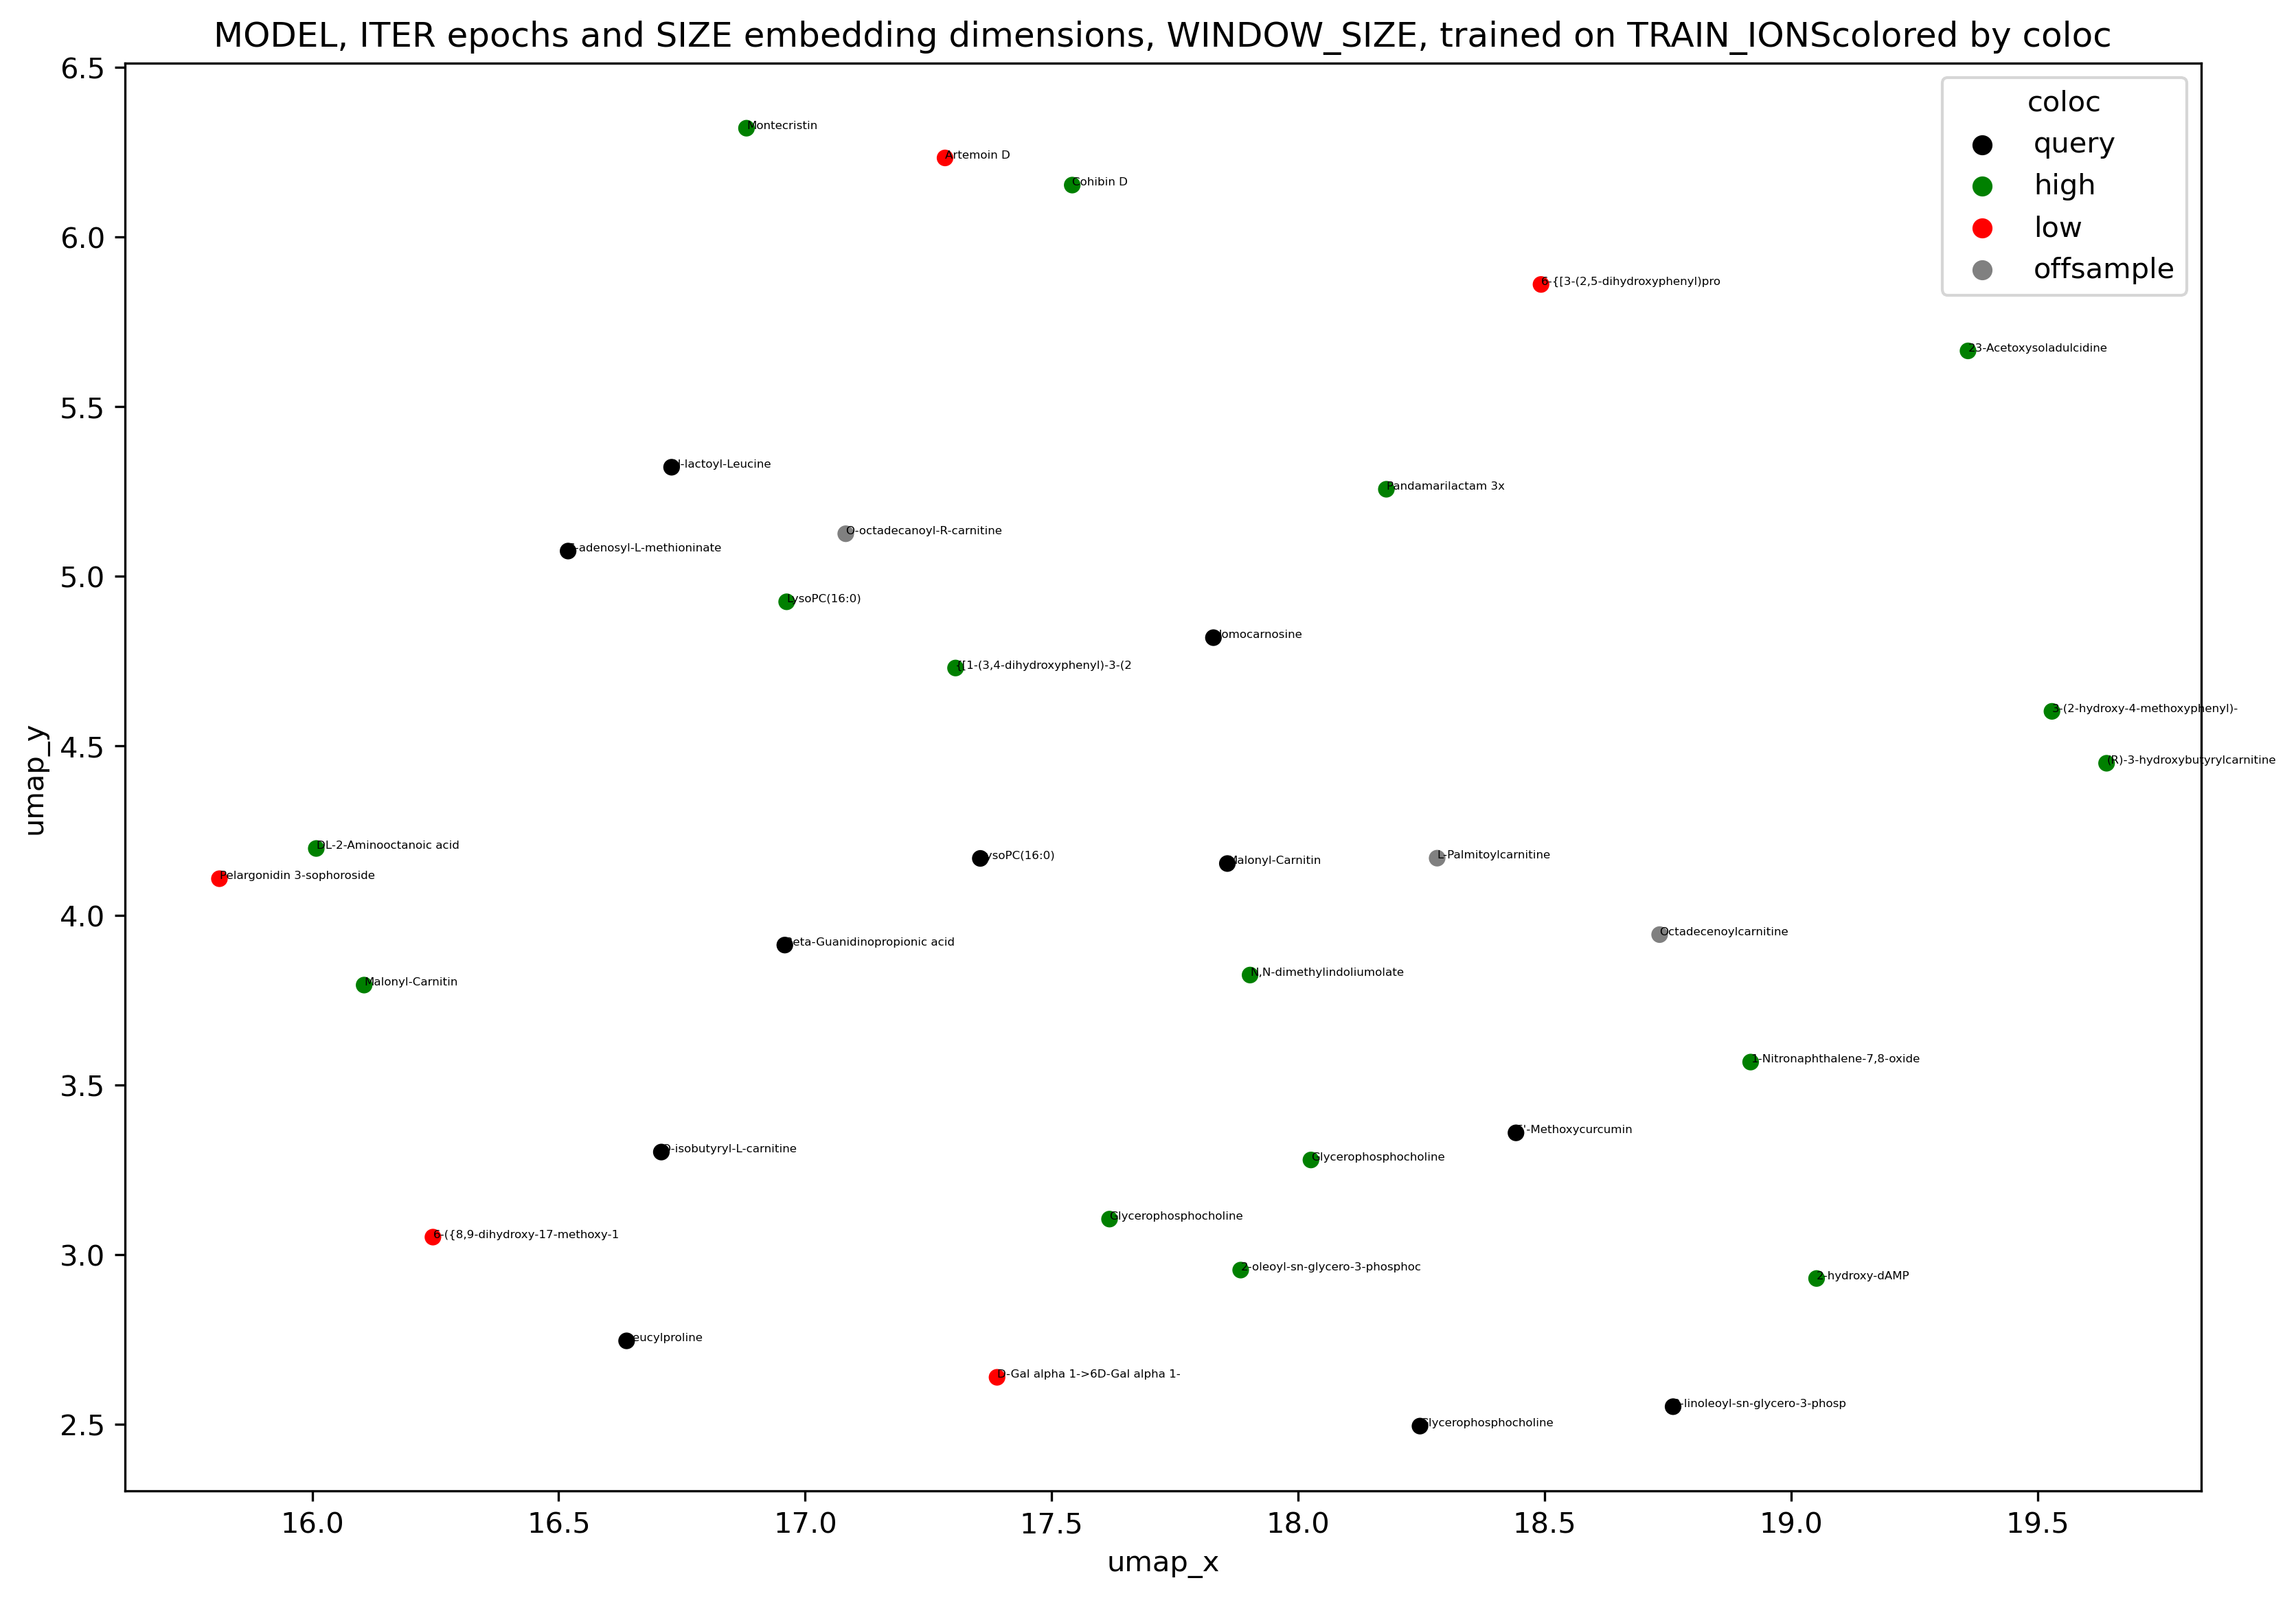

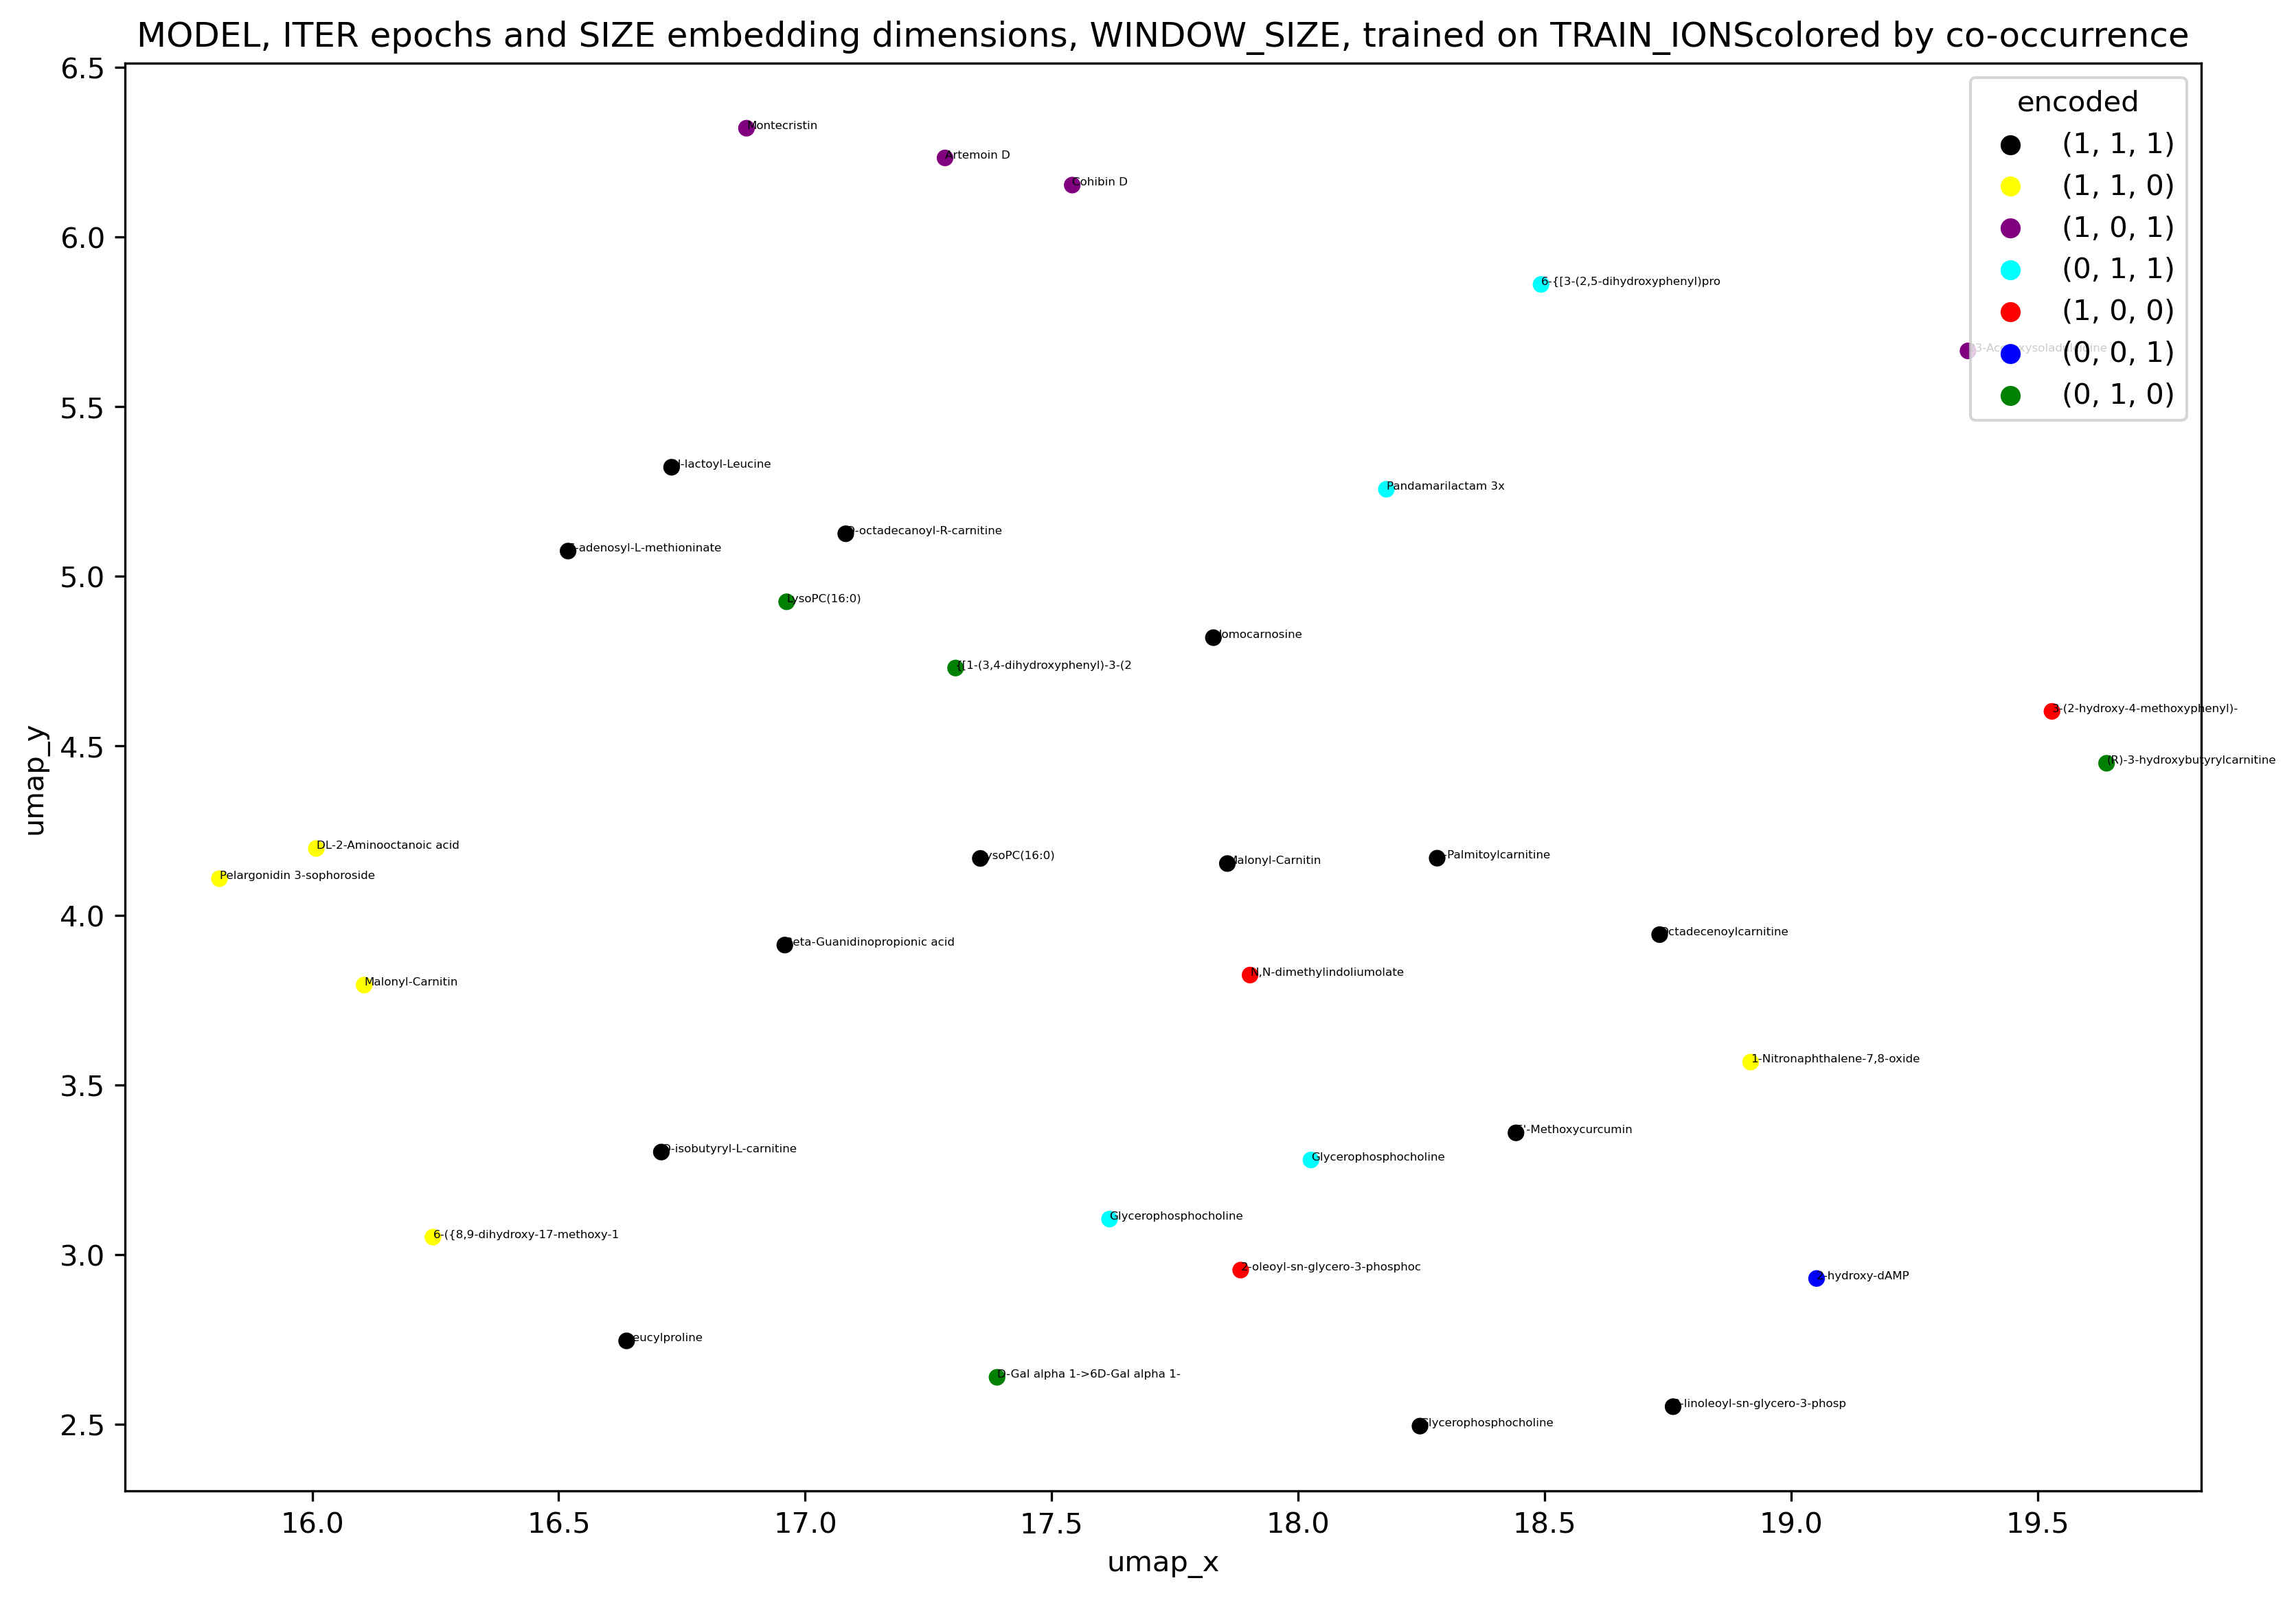

In [9]:
ax = sns.scatterplot(query_df, x = 'umap_x', y='umap_y', hue='coloc', palette=color_dict, s=40)
ax.set_title(title + 'colored by coloc')
label_point(query_df['umap_x'], query_df['umap_y'], query_df['mol_name'], ax, size=4)
#plt.savefig(save_str + 'umap_coloc.png')
plt.show()
ax = sns.scatterplot(query_df, x = 'umap_x', y='umap_y', hue='encoded', palette=color_dict, s=40)
ax.set_title(title + 'colored by co-occurrence')
label_point(query_df['umap_x'], query_df['umap_y'], query_df['mol_name'], ax, size=4)
#plt.savefig(save_str + 'umap_encoded.png', format='png')
plt.show()


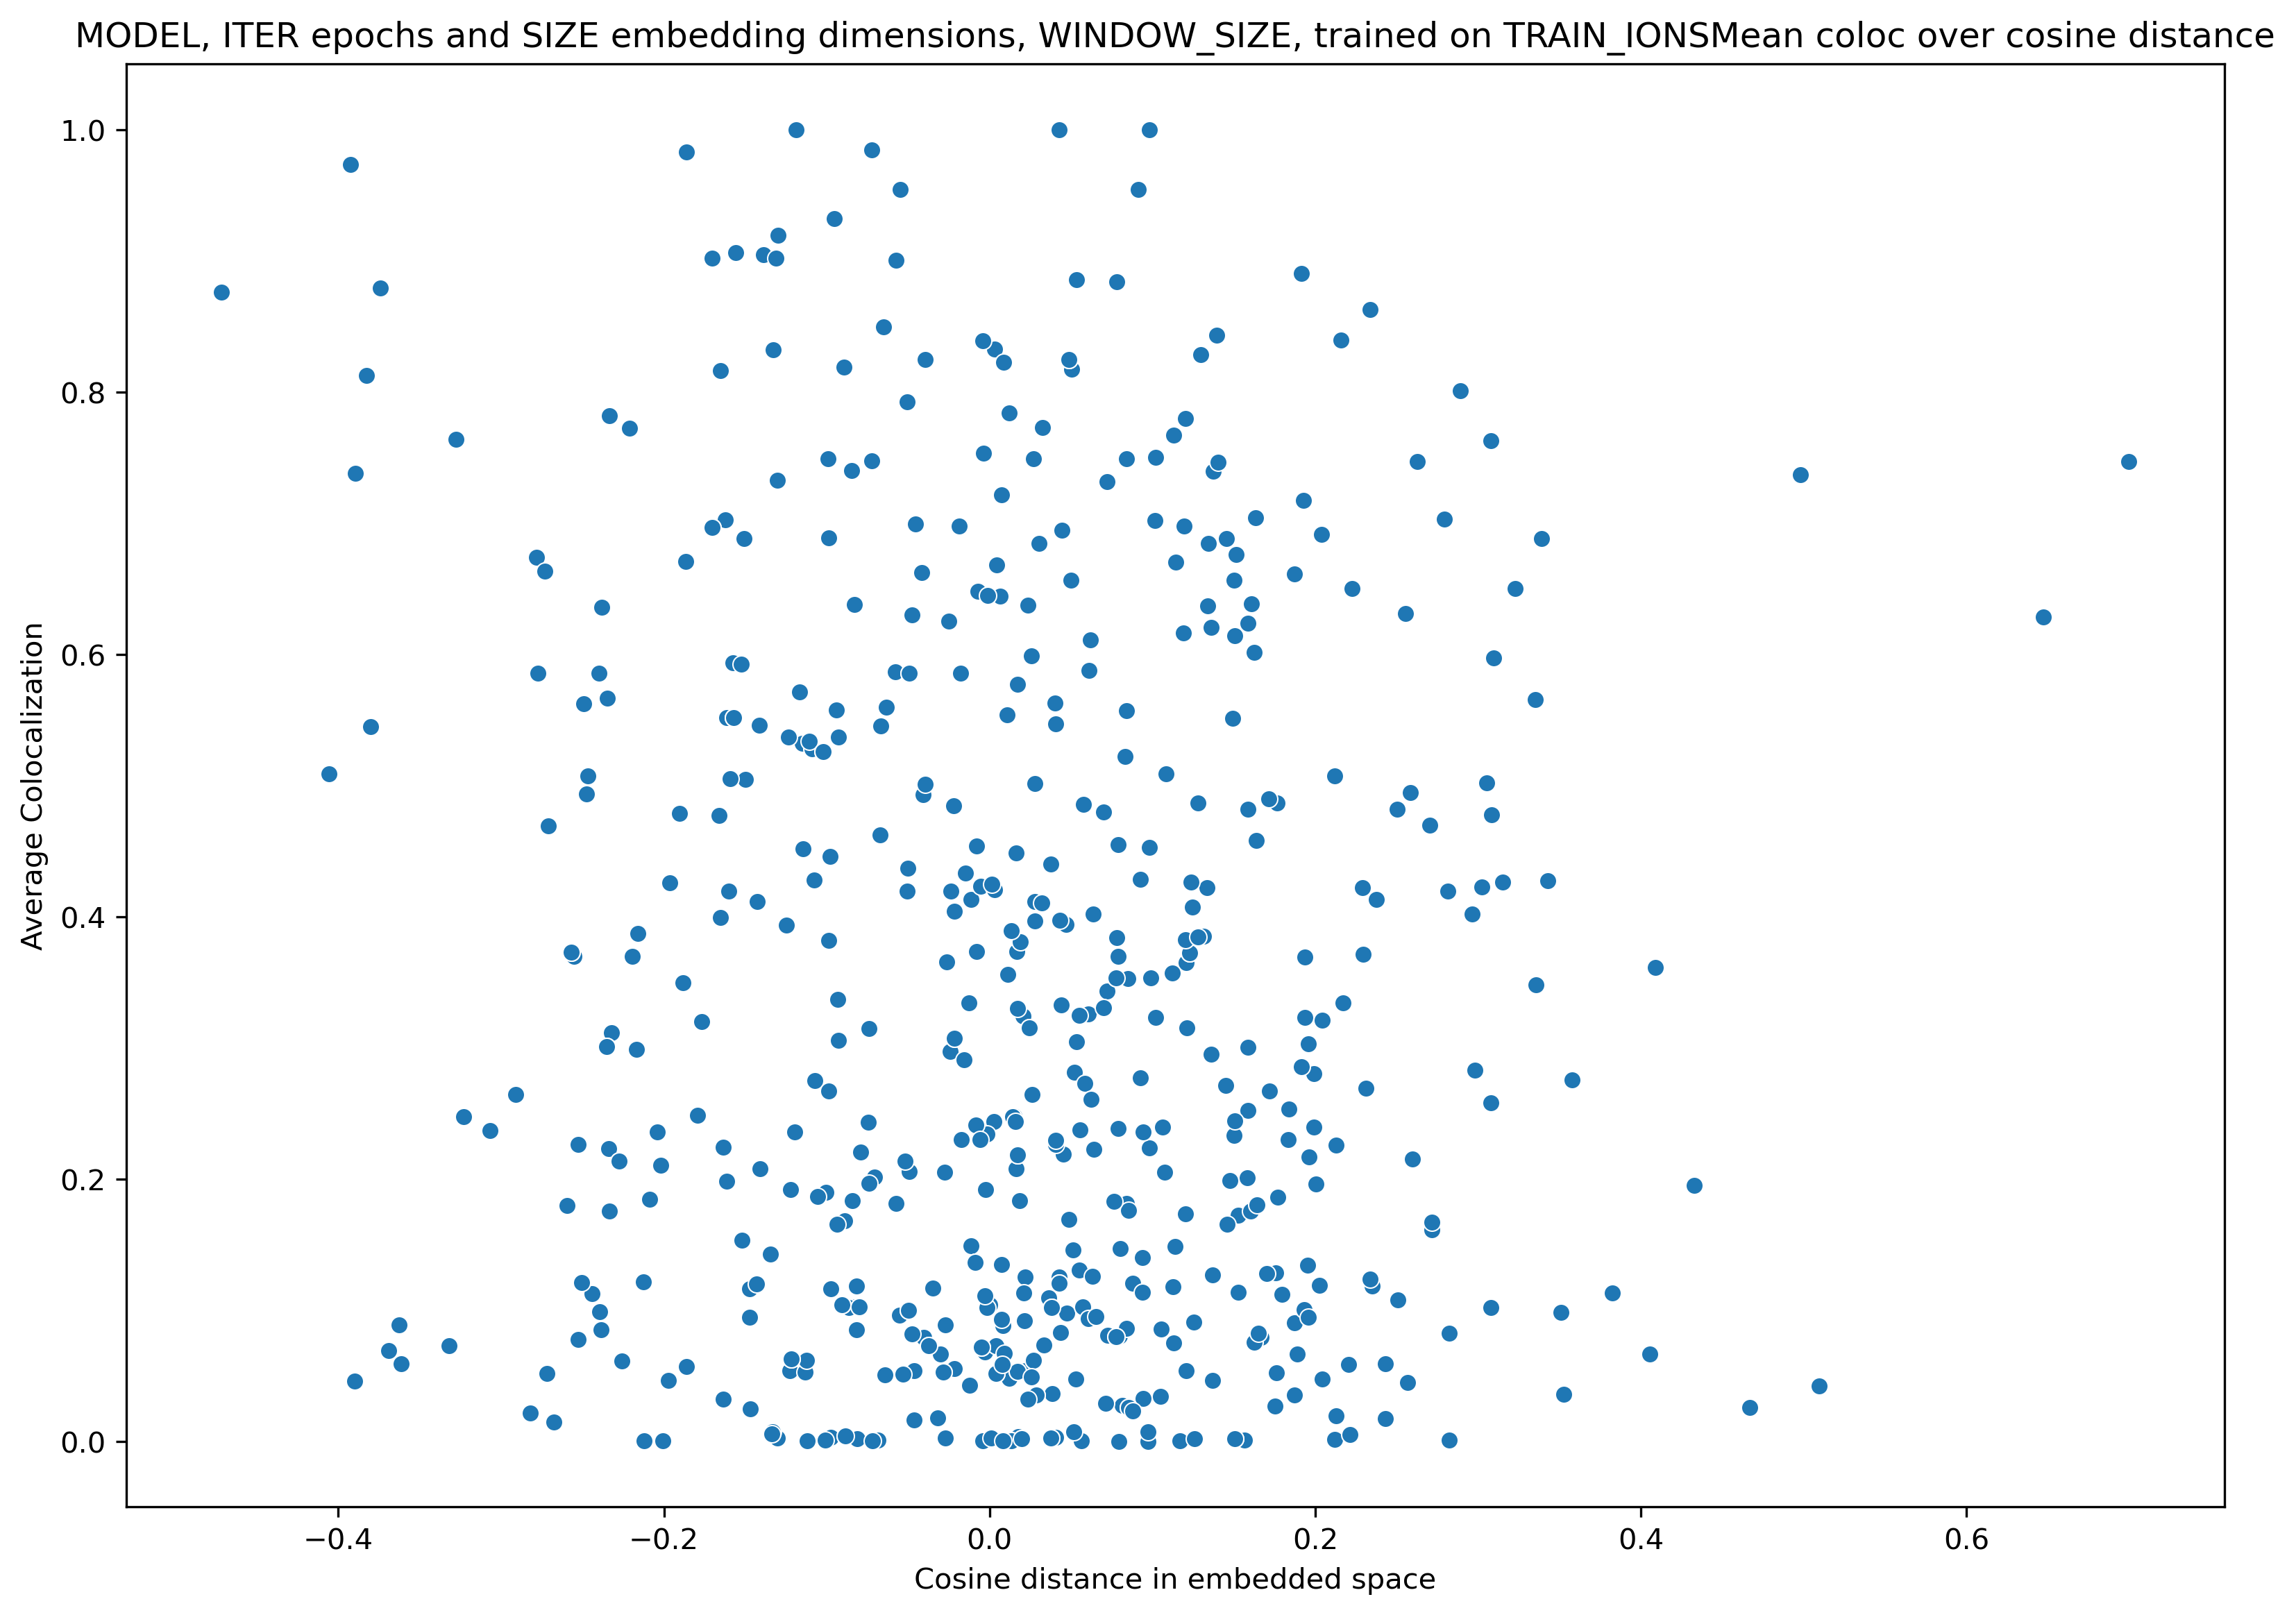

In [11]:
cos_coloc = cos_coloc_dict(col_df, cos_df)
xy = np.array(list(cos_coloc.values()))
ax = sns.scatterplot(x = xy[:,0], y= xy[:,1])
ax.set_title(title + 'Mean coloc over cosine distance')
ax.set_ylabel('Average Colocalization')
ax.set_xlabel('Cosine distance in embedded space')
#plt.savefig(save_str + 'cos_over_coloc.png', format='png')
plt.show()


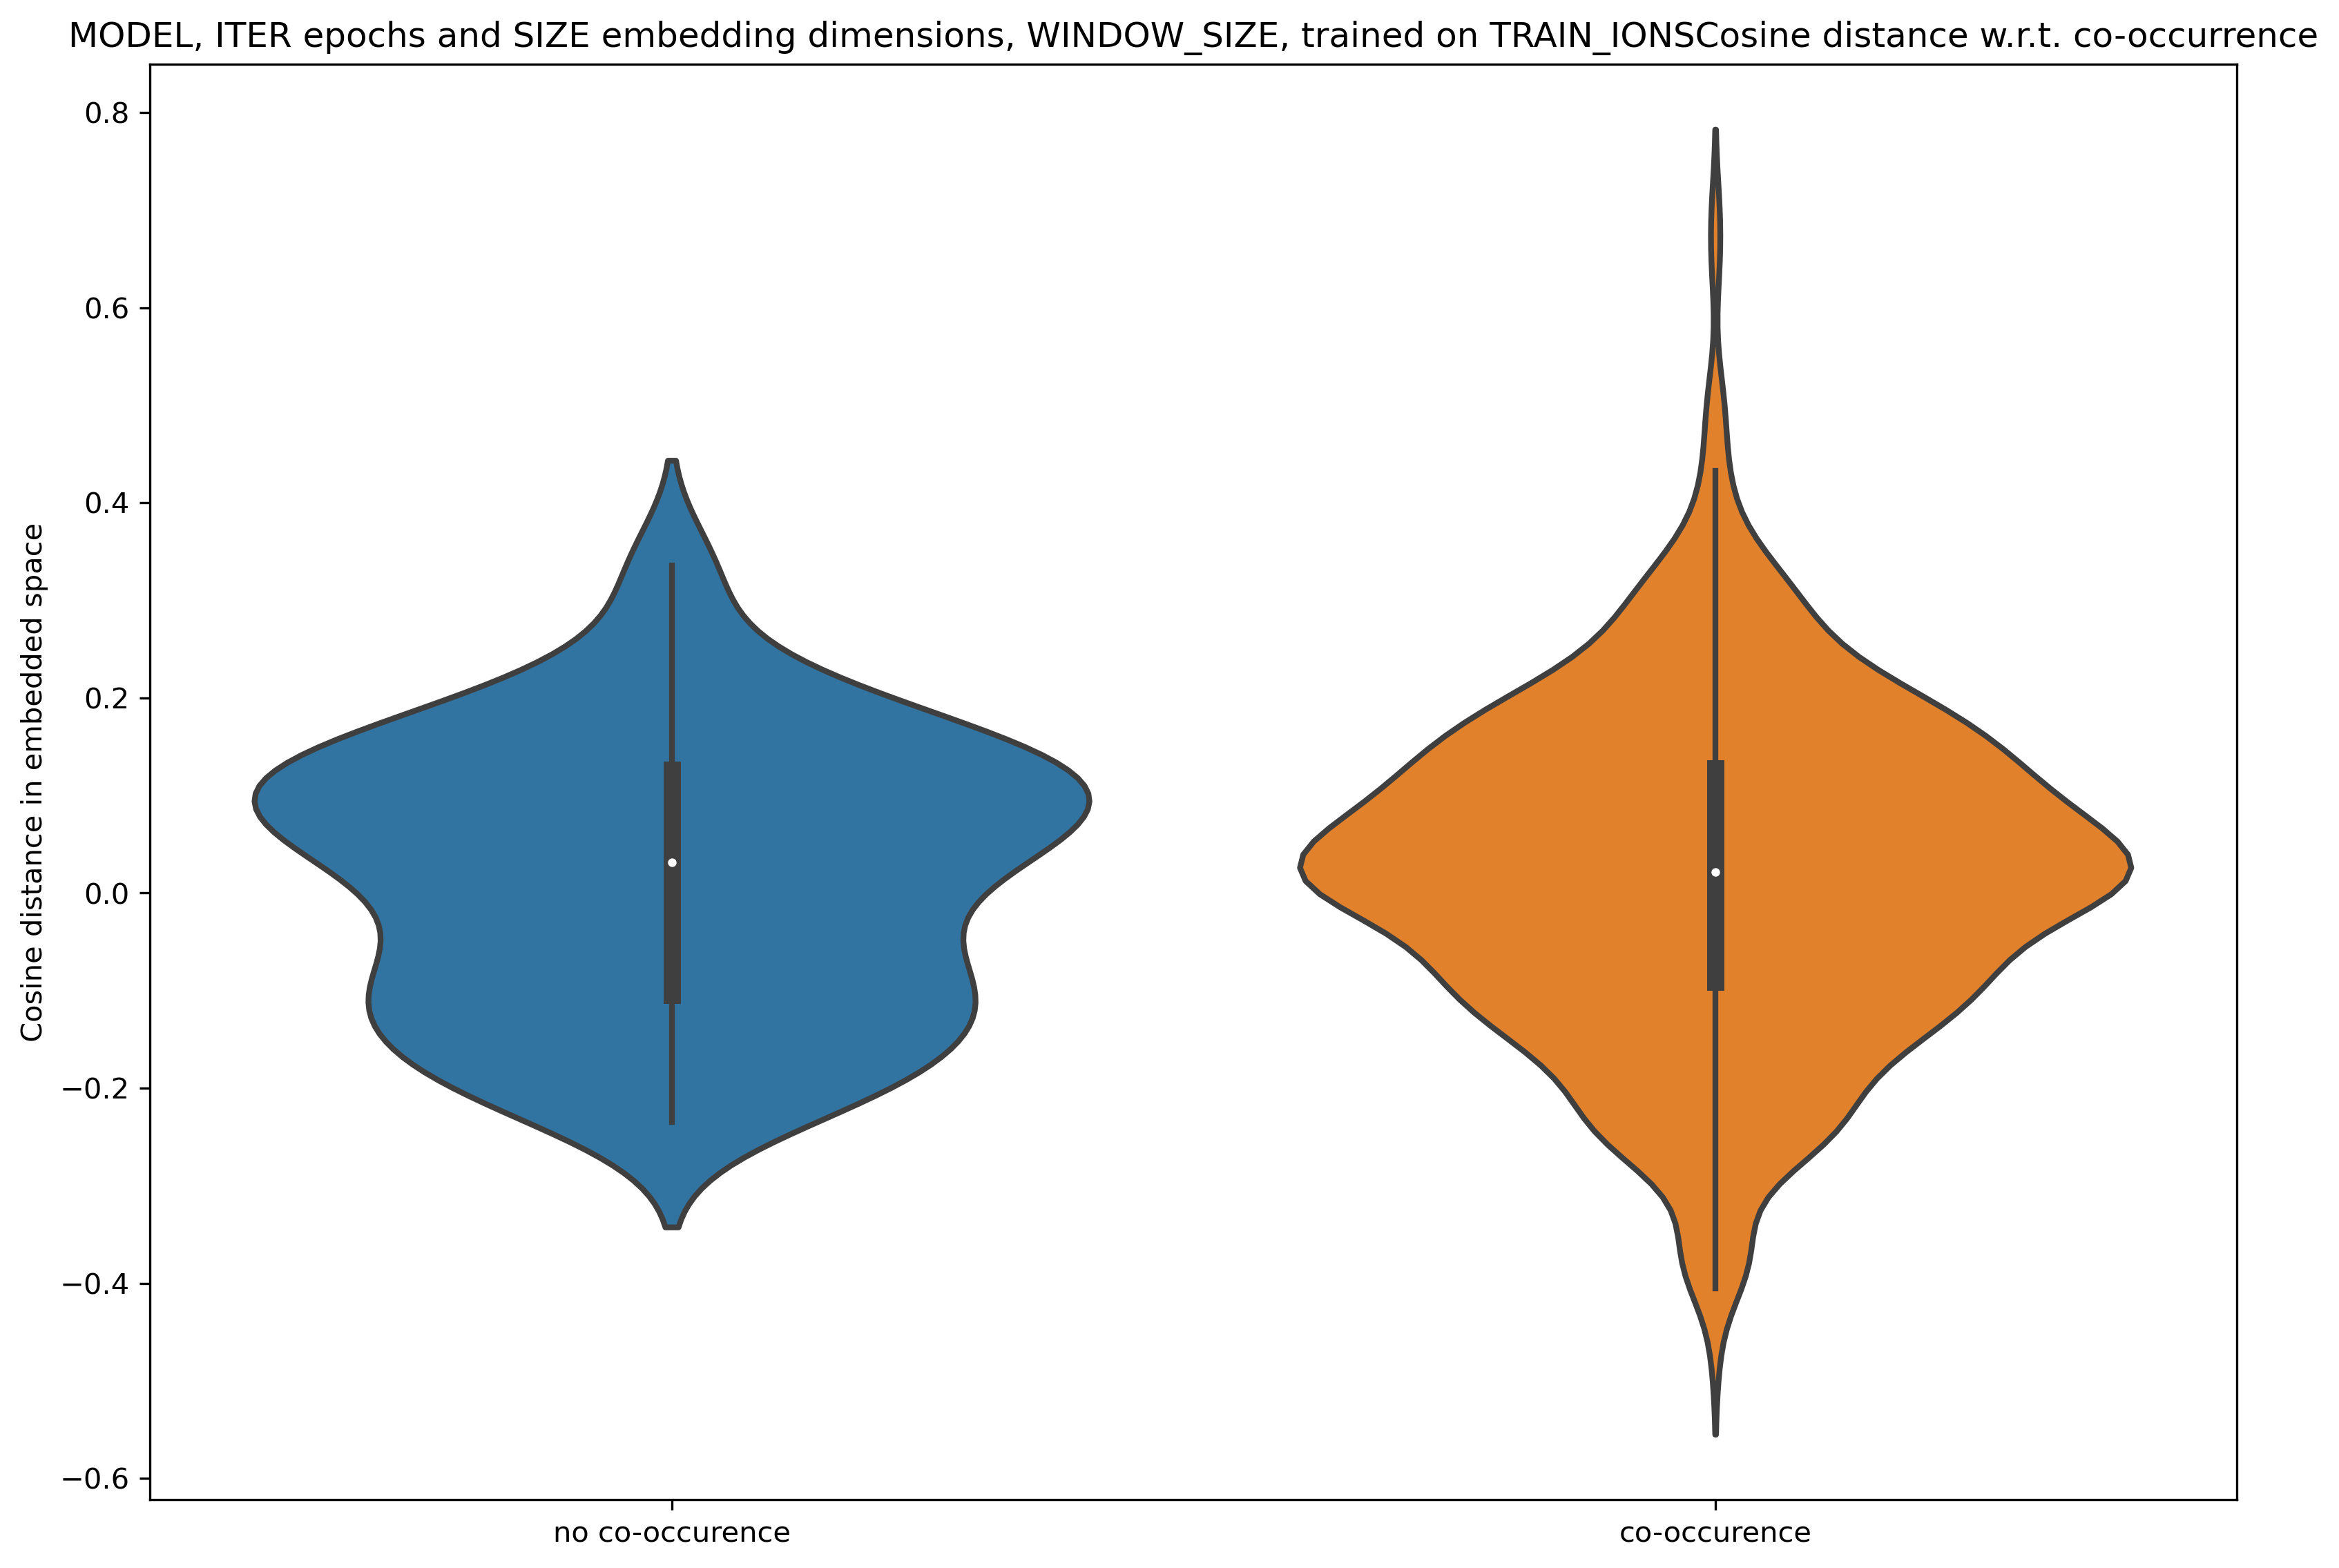

In [12]:
no_dist, co_dist = noco_distances(col_df, cos_df)
ax = sns.violinplot([list(no_dist.values()), list(co_dist.values())], 
linewidth=2, fliersize=2)
ax.set_ylabel('Cosine distance in embedded space')
ax.set_title(title + 'Cosine distance w.r.t. co-occurrence')
ax.set_xticklabels(labels=['no co-occurence', 'co-occurence'])
#plt.savefig(save_str + 'cos_violin.png', format='png')
plt.show()